# Open Data From JSON

In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [3]:
len(df["maintext"])

9306

# Preprocessing 

In [4]:
import re

In [5]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [6]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [7]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
        	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

df["maintext_nouns"] = nouns

In [9]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

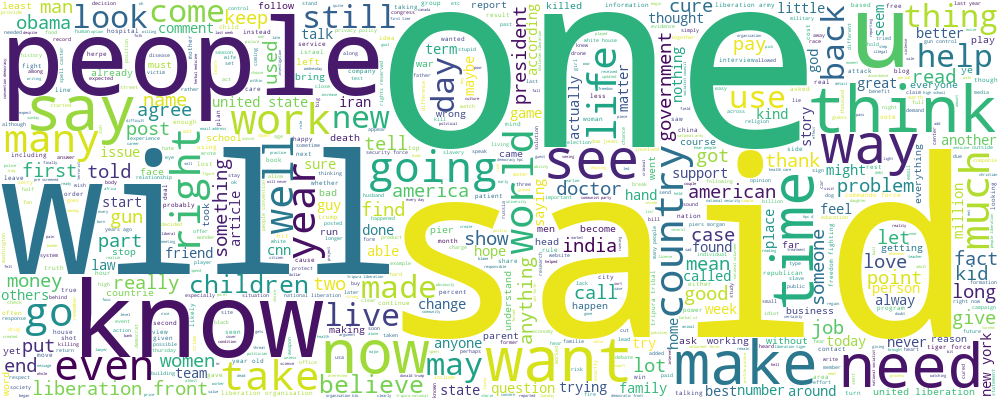

In [11]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

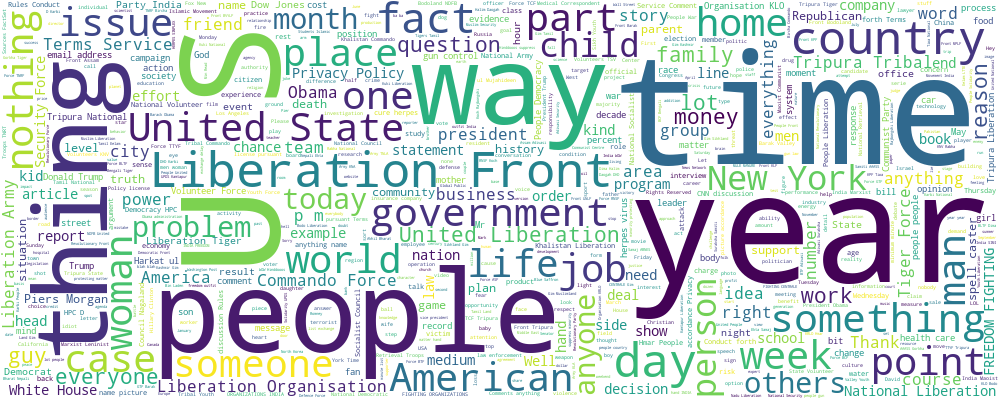

In [12]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [13]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


In [15]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [16]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [17]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
df["maintext_ready"]  = maintext_ready

In [18]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa..."


# Wordcloud of the ready-to-cluster articles

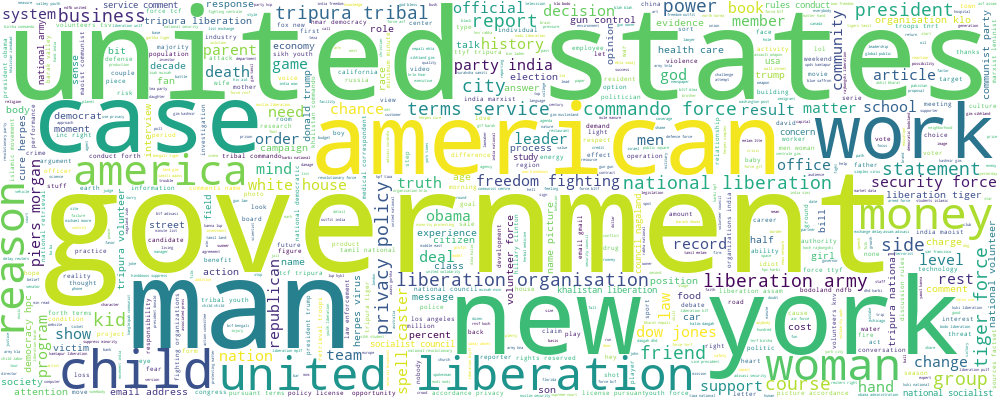

In [19]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

In [20]:
import gensim.corpora as corpora

In [21]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [22]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (19, 1), (33, 1), (34, 2), (64, 16),..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(10, 4), (15, 1), (19, 1), (21, 1), (33, 1), ..."


# Build a LDA model (need to find fitting values here)

In [23]:
from pprint import pprint   #pretty printing

In [24]:
amount_of_topics = 20  #adjust to find good results

In [25]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics)   #build the LDA model

# Displaying the LDA model

In [26]:
pprint(lda_model.print_topics())
articles_lda = lda_model[corpus]

[(0,
  '0.004*"president" + 0.004*"india" + 0.003*"man" + 0.003*"news" + '
  '0.003*"child" + 0.003*"money" + 0.003*"modi" + 0.003*"obama" + 0.003*"data" '
  '+ 0.003*"liberation"'),
 (1,
  '0.011*"force" + 0.009*"liberation" + 0.008*"tripura" + 0.008*"national" + '
  '0.006*"india" + 0.005*"united" + 0.004*"army" + 0.004*"service" + '
  '0.004*"child" + 0.003*"party"'),
 (2,
  '0.011*"force" + 0.009*"liberation" + 0.008*"tripura" + 0.007*"india" + '
  '0.005*"national" + 0.004*"united" + 0.004*"gun" + 0.004*"child" + '
  '0.004*"army" + 0.003*"security"'),
 (3,
  '0.010*"liberation" + 0.009*"national" + 0.009*"force" + 0.009*"tripura" + '
  '0.007*"piers" + 0.005*"india" + 0.004*"united" + 0.004*"gun" + 0.004*"army" '
  '+ 0.004*"man"'),
 (4,
  '0.006*"child" + 0.005*"obama" + 0.004*"school" + 0.004*"washington" + '
  '0.003*"america" + 0.003*"president" + 0.003*"house" + 0.003*"law" + '
  '0.003*"gun" + 0.003*"woman"'),
 (5,
  '0.006*"president" + 0.006*"obama" + 0.005*"iran" + 0.005

# Visualize the LDA model for further analysis (needed to find the best values to adjust)

In [27]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

In [28]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.023331  0.020322       1        1  11.825200
1      0.039006  0.007588       2        1   9.221504
6     -0.039478  0.007502       3        1   9.103339
13    -0.000225 -0.032994       4        1   9.037639
10    -0.001218 -0.003316       5        1   6.920296
16     0.000008  0.007175       6        1   6.428442
12    -0.019248 -0.005083       7        1   6.158503
19    -0.016838  0.006554       8        1   5.530138
15    -0.022388 -0.002210       9        1   5.031536
0     -0.014287  0.000595      10        1   4.862974
4     -0.027739 -0.007434      11        1   4.855666
8      0.010377 -0.009408      12        1   4.529483
11    -0.003446 -0.000485      13        1   3.351628
9     -0.009232 -0.004092      14        1   2.813266
17     0.004769  0.001125      15        1   2.739054
3      0.037197 -0.001979      16        1   2.379808
7      0.008747 -0.001510      17        1   2.056623
18     0.023471 -0.000621      18        1   1.429431
2      0.032943  0.000021      19        1   0.912847
14     0.020911  0.018249      20        1   0.812622, topic_info=            Term          Freq         Total Category  logprob  loglift
355   liberation  15161.000000  15161.000000  Default  30.0000  30.0000
253        force  19218.000000  19218.000000  Default  29.0000  29.0000
501      tripura  12262.000000  12262.000000  Default  28.0000  28.0000
390     national  13191.000000  13191.000000  Default  27.0000  27.0000
290        india  13374.000000  13374.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1150  government     80.323781  11337.016691  Topic20  -6.1024  -0.1371
988        house     71.956247   9194.181941  Topic20  -6.2124  -0.0376
708        money     73.314301  10767.918320  Topic20  -6.1937  -0.1769
93         right     73.701826  11057.572940  Topic20  -6.1884  -0.1982
69          news     73.545990  12304.101860  Topic20  -6.1906  -0.3071

[1746 rows x 6 columns], token_table=        Topic      Freq         Term
term                                
99687       7  0.795088       abaygo
104126      3  0.077334  abdulmumini
104126      4  0.077334  abdulmumini
104126      5  0.077334  abdulmumini
104126      9  0.232001  abdulmumini
...       ...       ...          ...
97417       8  0.048949   欣赏一周精彩纷呈图片
97417       9  0.636343   欣赏一周精彩纷呈图片
97417      10  0.097899   欣赏一周精彩纷呈图片
97417      14  0.048949   欣赏一周精彩纷呈图片
97417      18  0.048949   欣赏一周精彩纷呈图片

[8576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 14, 11, 17, 13, 20, 16, 1, 5, 9, 12, 10, 18, 4, 8, 19, 3, 15])

# Store Cluster IDs to dataframe

In [29]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(16, '0.008*"gun" + 0.005*"liberation" + 0.004*"force" + 0.004*"government" + 0.004*"president"')
(5, '0.006*"president" + 0.006*"obama" + 0.005*"iran" + 0.005*"trump" + 0.004*"herpes"')
(10, '0.005*"doctor" + 0.004*"liberation" + 0.004*"force" + 0.004*"herpes" + 0.004*"president"')
(18, '0.008*"liberation" + 0.008*"force" + 0.005*"tripura" + 0.005*"national" + 0.005*"india"')
(0, '0.004*"president" + 0.004*"india" + 0.003*"man" + 0.003*"news" + 0.003*"child"')
(1, '0.011*"force" + 0.009*"liberation" + 0.008*"tripura" + 0.008*"national" + 0.006*"india"')
(12, '0.003*"president" + 0.003*"obama" + 0.003*"right" + 0.003*"school" + 0.003*"doctor"')
(15, '0.005*"game" + 0.005*"woman" + 0.004*"right" + 0.003*"doctor" + 0.003*"team"')
(2, '0.011*"force" + 0.009*"liberation" + 0.008*"tripura" + 0.007*"india" + 0.005*"national"')
(7, '0.005*"liberation" + 0.005*"tripura" + 0.004*"india" + 0.004*"force" + 0.004*"national"')
C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel

In [30]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for i, row in enumerate(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):   #get the dominant topic for each article
        if j == 0:  #dominant topic (only first one)
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            topic_list.append(int(topic_num))
            topic_percentage_list.append(round(prop_topic,5))
            topic_keywords_list.append(topic_keywords)
        else: 
            break

df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
df.head(3)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",13,0.99466,"child, school, gun, india, force, money, docto..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (19, 1), (33, 1), (34, 2), (64, 16),...",1,0.90478,"force, liberation, tripura, national, india, u..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(10, 4), (15, 1), (19, 1), (21, 1), (33, 1), ...",0,0.68345,"president, india, man, news, child, money, mod..."


In [32]:
def getMonthYear(s):
     return s.split('-')[0]+"-"+s.split('-')[1]

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
df['date_publish'] = pd.to_datetime(df['date_publish'])
df['date_modify'] = pd.to_datetime(df['date_modify'])
df['date_download'] = pd.to_datetime(df['date_download'])
df['month_year'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
df.head(3)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords,month_year
0,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:54:29,Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",13,0.99466,"child, school, gun, india, force, money, docto...",2020-01
1,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:39:12,For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (19, 1), (33, 1), (34, 2), (64, 16),...",1,0.90478,"force, liberation, tripura, national, india, u...",2020-01
2,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:06:12,For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(10, 4), (15, 1), (19, 1), (21, 1), (33, 1), ...",0,0.68345,"president, india, man, news, child, money, mod...",2020-01


In [34]:
for cluster_id, data in df.groupby(df.clusterID):
    item = data.topic_keywords.iloc[0].split(",")
    os.makedirs(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}')
    for date, _ in data.groupby(data.month_year):
        data.to_json(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}/{date}.json', orient='records', force_ascii=False, indent=2)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
